# Predict ED admission probability

This notebook demonstrates the first stage of prediction, to generate a probability of admission for each patient in the ED. 

As one of the modelling decisions is to send predictions at specified times of day, we tailor the models to these times and train one model for each time. The dataset used for this modelling is derived from snapshots of visits at each time of day. The times of day are define in config.json file in the root directory of this repo. 

A patient episode (visit) may well span more than one of these times, so we need to consider how we will deal with the occurence of multiple snapshots per episode. At each of these times of day, we will use only one training sample from each hospital episode.

Separation of the visits into training, validation and test sets will be done chronologically into a training, validation and test set 

Evaluation of individual level models includes: 
- feature importance plots
- calibration plot
- MADCAP overall, plus breakdown by age category and length of stay


## Set up the notebook environment

In [6]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [7]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))



In [8]:
model_file_path = PROJECT_ROOT /'data' / 'ed-predictor' / 'trained-models'
model_file_path

data_file_path = USER_ROOT / 'ed-predictor' / 'data-raw'
data_file_path

media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [9]:
# Load the times of day
import yaml

config_path = Path(USER_ROOT / 'patientflow')

with open(config_path / 'config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
# Convert list of times of day at which predictions will be made (currently stored as lists) to list of tuples
prediction_times = [tuple(item) for item in config['prediction_times']]

# See the times of day at which predictions will be made
prediction_times

# Load the dates defining the beginning and end of training, validation and test sets
start_training_set, start_validation_set, start_test_set, end_test_set = [item for item in config['modelling_dates']]


## Load data

In [10]:
from ed_admissions_data_retrieval import ed_admissions_get_data

csv_filename = 'ed_visits.csv'
full_path = data_file_path / csv_filename

visits = ed_admissions_get_data(full_path)

In [11]:
visits.sex.value_counts()

sex
F    105580
M     96419
U       214
I        66
Name: count, dtype: int64

In [12]:
visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date

In [13]:
# print start and end dates
print(visits.snapshot_date.min())
print(visits.snapshot_date.max())

2030-04-01
2032-04-30


See how many visits there are at each time of day in the dataset. We see that number of visits represented is greater in the afternoon and evening

In [14]:
print(visits.prediction_time.value_counts())

prediction_time
(15, 30)    57854
(22, 0)     47984
(12, 0)     47535
(9, 30)     28567
(6, 0)      20339
Name: count, dtype: int64


We will confirm that the dataset aligns with the specified times of day set in the parameters file config.yaml. That is because, later, we will use these times of day to evaluate the predictions. The evaluation will fail if the data loaded does not match. 

In [15]:
print("\nTimes of day at which predictions will be made")
print(prediction_times)
print("\nNumber of rows in dataset that are not in these times of day")
print(len(visits[~visits.prediction_time.isin(prediction_times)]))


Times of day at which predictions will be made
[(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]

Number of rows in dataset that are not in these times of day
0


## Set an index column in visits

Setting the index as the snapshot_id before subsetting means that we retain the same values of snapshot_id throughout the entire process, ensuring that they are consistent across the original dataset visits and the training, validation and test subsets of visits

In [16]:
visits.head()

,snapshot_id,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,...,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_hco3,training_validation_test,is_admitted,random_number
0,0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,False,121958
1,1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,...,4.2,0.5,141.0,6.84,7.371,5.28,NaN,train,False,146867
2,2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,False,131932
3,3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,...,5.8,1.2,136.0,5.41,7.371,14.10,NaN,train,True,103694
4,4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,False,119879


After executing the code below, the snapshot_id has been set as the index column.

In [17]:
if visits.index.name != 'snapshot_id':
    visits = visits.set_index('snapshot_id')
visits.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_hco3,training_validation_test,is_admitted,random_number
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,False,121958
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,4.2,0.5,141.0,6.84,7.371,5.28,NaN,train,False,146867
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,False,131932
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,400.0,...,5.8,1.2,136.0,5.41,7.371,14.10,NaN,train,True,103694
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,False,119879


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. This has been done chronologically, as shown by the output below. Using a chronological approach is appropriate for tasks where the model needs to be validated on unseen, future data.


In [18]:
visits.columns

Index(['snapshot_date', 'prediction_time', 'visit_number', 'elapsed_los',
       'sex', 'age_group', 'arrival_method', 'current_location_type',
       'total_locations_visited', 'num_obs', 'num_obs_events', 'num_obs_types',
       'num_lab_batteries_ordered', 'has_consultation', 'visited_majors',
       'visited_otf', 'visited_paeds', 'visited_rat', 'visited_resus',
       'visited_sdec', 'visited_sdec_waiting', 'visited_taf',
       'visited_unknown', 'visited_utc', 'visited_waiting', 'num_obs_pulse',
       'num_obs_air_or_oxygen', 'num_obs_level_of_consciousness',
       'num_obs_uclh_ed_manchester_triage_calculated_acuity',
       'num_obs_uclh_ed_manchester_triage_objective_pain_score',
       'num_obs_uclh_ed_manchester_triage_subjective_pain_score',
       'num_obs_temperature', 'num_obs_blood_pressure',
       'num_obs_glasgow_coma_scale_best_motor_response',
       'num_obs_news_score_result', 'num_obs_oxygen_delivery_method',
       'num_obs_oxygen_flow_rate', 'num_obs_pupil_

In [20]:
# visits = visits.drop(columns = ['has_bed_request'])

In [21]:
print(len(visits))
# remove visits > 24 hours
# visits = visits[visits.elapsed_los <= 24*60*60]
visits = visits.drop(columns = ['latest_lab_results_hco3'])
print(len(visits))


202279
202279


In [22]:
for value in visits.training_validation_test.unique():
    subset = visits[visits.training_validation_test == value]
    counts = subset.training_validation_test.value_counts().values[0]
    min_date = subset.snapshot_date.min()
    max_date = subset.snapshot_date.max()
    print(f"Set: {value}\nNumber of rows: {counts}\nMin Date: {min_date}\nMax Date: {max_date}\n")

Set: train
Number of rows: 145646
Min Date: 2030-04-01
Max Date: 2031-08-31

Set: test
Number of rows: 44961
Min Date: 2031-11-01
Max Date: 2032-04-30

Set: valid
Number of rows: 11672
Min Date: 2031-09-01
Max Date: 2031-10-31



In [23]:
train_visits = visits[visits.training_validation_test == 'train'].drop(columns='training_validation_test')
valid_visits = visits[visits.training_validation_test == 'valid'].drop(columns='training_validation_test')
test_visits = visits[visits.training_validation_test == 'test'].drop(columns='training_validation_test')


We can see below that some visits appear more than once in each of these sets. (No visit appears in more than one set.)

In [24]:
train_visits.visit_number.value_counts()

visit_number
17425.0     15
94235.0     15
107960.0    14
60764.0     14
96444.0     14
            ..
46415.0      1
46414.0      1
46413.0      1
46412.0      1
196144.0     1
Name: count, Length: 115941, dtype: int64

For example, the below patient has 16 episode slices. It's quite possible that this patient has already left the ED but the discharge has not been updated on the patient record. While it is tempting to remove these later, in real-time these patients would be picked up, so a model would ideally be trained on this data also. Therefore we do need to include them in our training set. 

In [25]:
train_visits[train_visits.visit_number == 17425.0].sort_values(['snapshot_date', 'prediction_time'])

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_hctu,latest_lab_results_htrt,latest_lab_results_k,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,is_admitted,random_number
snapshot_id,,,,,,,,,,,,,,,,,,,,,
19216,2030-06-06,"(22, 0)",17425.0,2071.0,M,75-102,Ambulance,rat,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,160466
19217,2030-06-07,"(6, 0)",17425.0,30871.0,M,75-102,Ambulance,majors,4.0,52.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,167243
19218,2030-06-07,"(9, 30)",17425.0,43471.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,61526
19219,2030-06-07,"(12, 0)",17425.0,52471.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,13149
19220,2030-06-07,"(15, 30)",17425.0,65071.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,161466
19221,2030-06-07,"(22, 0)",17425.0,88471.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,145468
19222,2030-06-08,"(6, 0)",17425.0,117271.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,154396
19223,2030-06-08,"(9, 30)",17425.0,129871.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,178270
19224,2030-06-08,"(12, 0)",17425.0,138871.0,M,75-102,Ambulance,otf,5.0,71.0,...,0.276,18.0,4.7,NaN,138.0,NaN,NaN,3.7,False,112168


## Train a XGBoost Classifier for each time of day, and save the best model

The first step is to load a transformer for the ML training data to turn it into a format that our ML classifier can read. This is done using a function called create_column_transformer() which called ColumnTransfomer() a standard method in scikit-learn. This function could be changed for different input

The ColumnTransformer in scikit-learn is a tool that applies different transformations or preprocessing steps to different columns of a dataset in a single operation. OneHotEncoder converts categorical data into a format that can be provided to machine learning algorithms; without this, the model might interpret the categorical data as numerical, which would lead to incorrect results. With the OrdinalEncoder, categories are converted into ordered numerical values to reflect the inherent order in the age groups

We can also specify a grid of hyperparameters, so that the classifier will iterate though them to find the best fitting model. 

We are interested in predictions at different times of day. So we will train a model for each time of day. We will filter each visit so that it only appears once in the training data. A random number has already been included in the dataset to facilitate this.

We then iterate through the grid to find the best model for each time of day, keeping track of the best model and its results. 

The best model is saved, plus a dictionary of its metadata, including

* how many visits were in training, validation and test sets
* Area under ROC curve and log loss (performance metrics) for training (based on 5-fold cross validation), validation and test sets
* List of features and their importances in the model


#### Function for cross validation

The ML models will be trained across a range of different hyperparameter options. When evaluating the best model, we will save common ML metrics (AUC and logloss) and compare each model for the best (lowest) logloss. Apply a chronological approach to the cross-validation split is appropriate for tasks where the model needs to be validated on unseen, future data.

In [26]:

# import xgboost as xgb

from sklearn.model_selection import ParameterGrid, cross_validate
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    log_loss,
    roc_auc_score,
)
from joblib import dump, load

from ed_admissions_utils import get_model_name, preprocess_data
from ed_admissions_machine_learning import chronological_cross_validation, create_column_transformer, initialise_model

# initialize a dict to save information about the best models for each time of day
best_model_results_dict = {}

# Option to iterate through different hyperparameters for XGBoost
grid = {
    'n_estimators':[30], #, 40, 50],
    'subsample':[0.7], #, 0.8,0.9],
    'colsample_bytree': [0.7] #, 0.8, 0.9]
}

# certain columns are not used in training
exclude_from_training_data = [
    "visit_number",
    "snapshot_date",
    "prediction_time"]


ordinal_mappings = {
    "age_group": ["0-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-102"],
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_manch_triage": ["Blue", "Green", "Yellow", "Orange", "Red"],
    "latest_pain_objective": ["Nil", "Mild", "Moderate", "Severe\E\Very Severe", "Severe\\Very Severe"]
}


# Process each time of day
for prediction_time_ in prediction_times:

    print("\nProcessing :" + str(prediction_time_))

    # create a name for the model based on the time of day it is trained for
    MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', prediction_time_)

    # use this name in the path for saving best model
    full_path = model_file_path / MODEL__ED_ADMISSIONS__NAME 
    full_path = full_path.with_suffix('.joblib')

    # initialise data used for saving attributes of the model
    best_model_results_dict[MODEL__ED_ADMISSIONS__NAME] = {}
    best_valid_logloss = float('inf')
    results_dict = {}
    
    # get visits that were in at the time of day in question and preprocess the training, validation and test sets 
    X_train, y_train = preprocess_data(train_visits, prediction_time_, exclude_from_training_data)
    X_valid, y_valid = preprocess_data(valid_visits, prediction_time_, exclude_from_training_data)
    X_test, y_test = preprocess_data(test_visits, prediction_time_, exclude_from_training_data)
    
    # save size of each set
    best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['train_valid_test_set_no'] = {
        'train_set_no' : len(X_train),
        'valid_set_no' : len(X_valid),
        'test_set_no' : len(X_test),
    }

    # iterate through the grid of hyperparameters
    for g in ParameterGrid(grid):
        model = initialise_model(g)
        
        # define a column transformer for the ordinal and categorical variables
        column_transformer = create_column_transformer(X_test, ordinal_mappings)
        
        # create a pipeline with the feature transformer and the model
        pipeline = Pipeline([
            ('feature_transformer', column_transformer),
            ('classifier', model)
        ])

        # cross-validate on training set using the function created earlier
        cv_results = chronological_cross_validation(pipeline, X_train, y_train, n_splits=5)

        # Store results for this set of parameters in the results dictionary
        results_dict[str(g)] = {
            'train_auc': cv_results['train_auc'],
            'valid_auc': cv_results['valid_auc'],
            'train_logloss': cv_results['train_logloss'],
            'valid_logloss': cv_results['valid_logloss'],
        }
        
        # Update and save best model if current model is better on validation set
        if cv_results['valid_logloss'] < best_valid_logloss:

            # save the details of the best model
            best_model = str(g)
            best_valid_logloss = cv_results['valid_logloss']

            # save the best model params
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['best_params'] = str(g)

            # save the model metrics on training and validation set
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['train_valid_set_results'] = results_dict

            # score the model's performance on the test set  
            y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, y_test_pred_proba)
            test_logloss = log_loss(y_test,y_test_pred_proba)
        
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['test_set_results'] = {
                'test_auc' : test_auc,
                'test_logloss' : test_logloss
            }

            # save the best features
            # To access transformed feature names:
            transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
            transformed_cols = [col.split('__')[-1] for col in transformed_cols]
            best_model_results_dict[MODEL__ED_ADMISSIONS__NAME]['best_model_features'] = {
                    'feature_names': transformed_cols,
                    'feature_importances': pipeline.named_steps['classifier'].feature_importances_.tolist()
                }

            # save the best model
            dump(pipeline, full_path)

# save the results dictionary      
filename_results_dict = 'best_model_results_dict.json'
full_path_results_dict = model_file_path / filename_results_dict

with open(full_path_results_dict, 'w') as f:
    json.dump(best_model_results_dict, f)  


Processing :(6, 0)

Processing :(9, 30)

Processing :(12, 0)

Processing :(15, 30)

Processing :(22, 0)


In [50]:
best_model_results_dict['ed_admission_2200']['test_set_results']

{'test_auc': 0.9017045989501631, 'test_logloss': 0.2652321958393627}

In [27]:
# without bed request snapshots, no bed request feature, and minorities retained; new data
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.8; log loss 0.396
Model: ed_admission_0930; AUC: 0.814; log loss 0.318
Model: ed_admission_1200; AUC: 0.822; log loss 0.291
Model: ed_admission_1530; AUC: 0.825; log loss 0.326
Model: ed_admission_2200; AUC: 0.835; log loss 0.359


In [29]:
# with bed request snapshots, but no bed request feature, and minorities retained
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.858; log loss 0.367
Model: ed_admission_0930; AUC: 0.886; log loss 0.267
Model: ed_admission_1200; AUC: 0.875; log loss 0.258
Model: ed_admission_1530; AUC: 0.868; log loss 0.28
Model: ed_admission_2200; AUC: 0.879; log loss 0.318


In [20]:
# without bed request snapshots, and minorities retained
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.804; log loss 0.271
Model: ed_admission_0930; AUC: 0.826; log loss 0.204
Model: ed_admission_1200; AUC: 0.817; log loss 0.211
Model: ed_admission_1530; AUC: 0.825; log loss 0.237
Model: ed_admission_2200; AUC: 0.826; log loss 0.27


In [21]:
# without bed request snapshots, and minorities removed
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.792; log loss 0.281
Model: ed_admission_0930; AUC: 0.83; log loss 0.204
Model: ed_admission_1200; AUC: 0.823; log loss 0.207
Model: ed_admission_1530; AUC: 0.819; log loss 0.239
Model: ed_admission_2200; AUC: 0.828; log loss 0.27


In [18]:
# with bed request snapshots and feature, and minorities removed
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.901; log loss 0.297
Model: ed_admission_0930; AUC: 0.909; log loss 0.227
Model: ed_admission_1200; AUC: 0.893; log loss 0.22
Model: ed_admission_1530; AUC: 0.89; log loss 0.243
Model: ed_admission_2200; AUC: 0.902; log loss 0.265


In [50]:
# with bed requests snapshots, and minorities removed 
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.86; log loss 0.361
Model: ed_admission_0930; AUC: 0.884; log loss 0.271
Model: ed_admission_1200; AUC: 0.877; log loss 0.253
Model: ed_admission_1530; AUC: 0.867; log loss 0.278
Model: ed_admission_2200; AUC: 0.881; log loss 0.317


In [22]:
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.791; log loss 0.281
Model: ed_admission_0930; AUC: 0.82; log loss 0.209
Model: ed_admission_1200; AUC: 0.805; log loss 0.213
Model: ed_admission_1530; AUC: 0.816; log loss 0.239
Model: ed_admission_2200; AUC: 0.823; log loss 0.275


In [54]:
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.799; log loss 0.278
Model: ed_admission_0930; AUC: 0.833; log loss 0.205
Model: ed_admission_1200; AUC: 0.81; log loss 0.213
Model: ed_admission_1530; AUC: 0.821; log loss 0.237
Model: ed_admission_2200; AUC: 0.826; log loss 0.273


In [22]:
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.866; log loss 0.354
Model: ed_admission_0930; AUC: 0.892; log loss 0.261
Model: ed_admission_1200; AUC: 0.875; log loss 0.253
Model: ed_admission_1530; AUC: 0.87; log loss 0.278
Model: ed_admission_2200; AUC: 0.884; log loss 0.313


## Evaluation

In [168]:
from ed_admissions_helper_functions import prepare_for_inference
csv_filename = 'ed_visits.csv'
full_path = data_file_path / csv_filename
X_test, y_test, model = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = prediction_time_, data_path = full_path, single_snapshot_per_visit = False, model_only = False)

/home/jovyan/work/ed-predictor/data-raw/ed_visits.csv


In [169]:
model

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(transformers=[('elapsed_los_td',
                                                  'passthrough',
                                                  ['elapsed_los_td']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('arrival_method',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['arrival_method']),
                                                 ('current_location_type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['current_location_type']),
                                                 ('to...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

In [1]:
# !pip install shap

In [58]:
prediction_times

[(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]

In [26]:
media_file_path / 'calibration_plot'

PosixPath('/home/jovyan/work/patientflow/notebooks/img/calibration_plot')

### Calibration plots

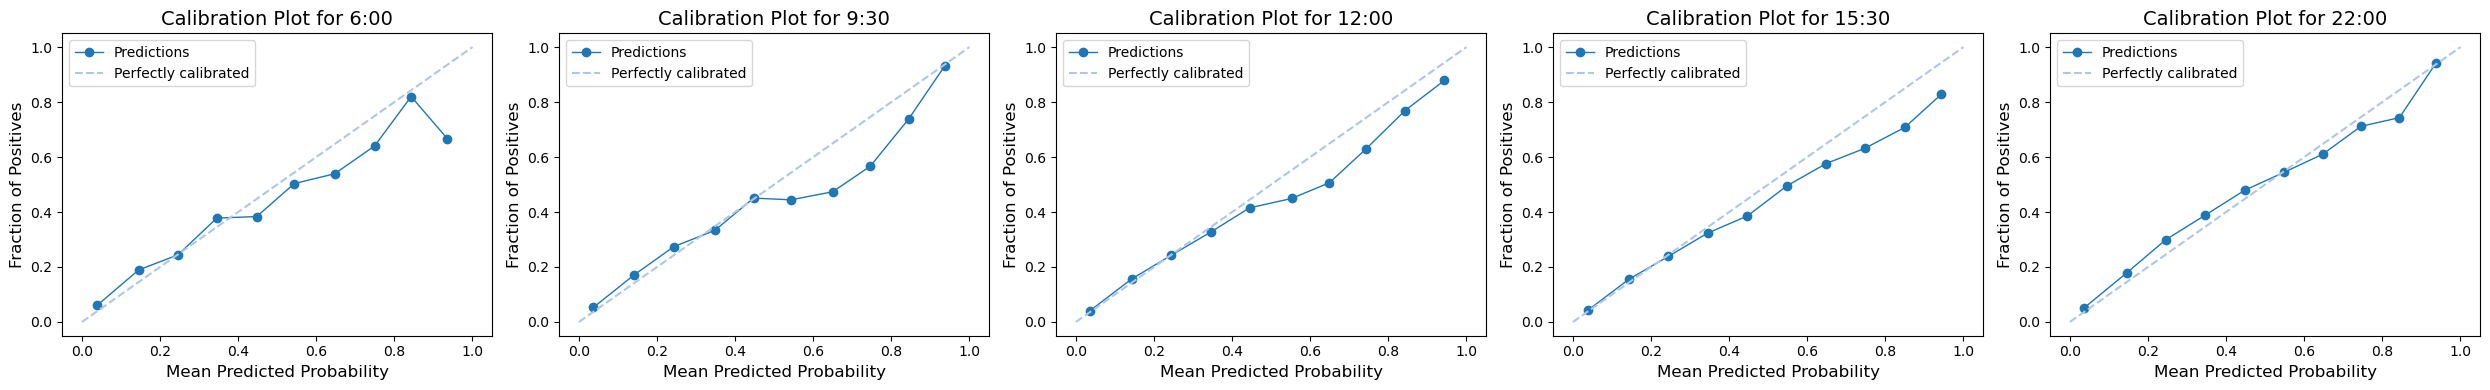

In [38]:
from ed_admissions_helper_functions import prepare_for_inference
from predict.emergency_demand.from_individual_probs import model_input_to_pred_proba
csv_filename = 'ed_visits.csv'
full_path = data_file_path / csv_filename

# Define the color scheme
primary_color = "#1f77b4"
secondary_color = "#aec7e8"


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

num_plots = len(prediction_times)
fig_sizes = [(num_plots * 5, 4), (num_plots * 6, 4), (10, 14), (num_plots * 8, 6)]

def plot_calibration(prediction_times):
    num_plots = len(prediction_times)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 5, 4))

    for i, prediction_time_ in enumerate(prediction_times):
        X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = prediction_time_, data_path = full_path, single_snapshot_per_visit = False, model_only = False)

        prob_true, prob_pred = calibration_curve(y_test, pipeline.predict_proba(X_test)[:, 1], n_bins=10)

        ax = axs[i]

        hour, minutes = prediction_time_

        ax.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Predictions', color=primary_color)
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color=secondary_color)
        ax.set_title(f'Calibration Plot for {hour}:{minutes:02}', fontsize = 14)
        ax.set_xlabel('Mean Predicted Probability', fontsize = 12)
        ax.set_ylabel('Fraction of Positives', fontsize = 12)
        ax.legend()

    plt.tight_layout()

    calib_plot_path = media_file_path / 'calibration_plot'
    calib_plot_path = calib_plot_path.with_suffix('.png')
    
    plt.savefig(calib_plot_path)
    plt.show()

    
plot_calibration(prediction_times)

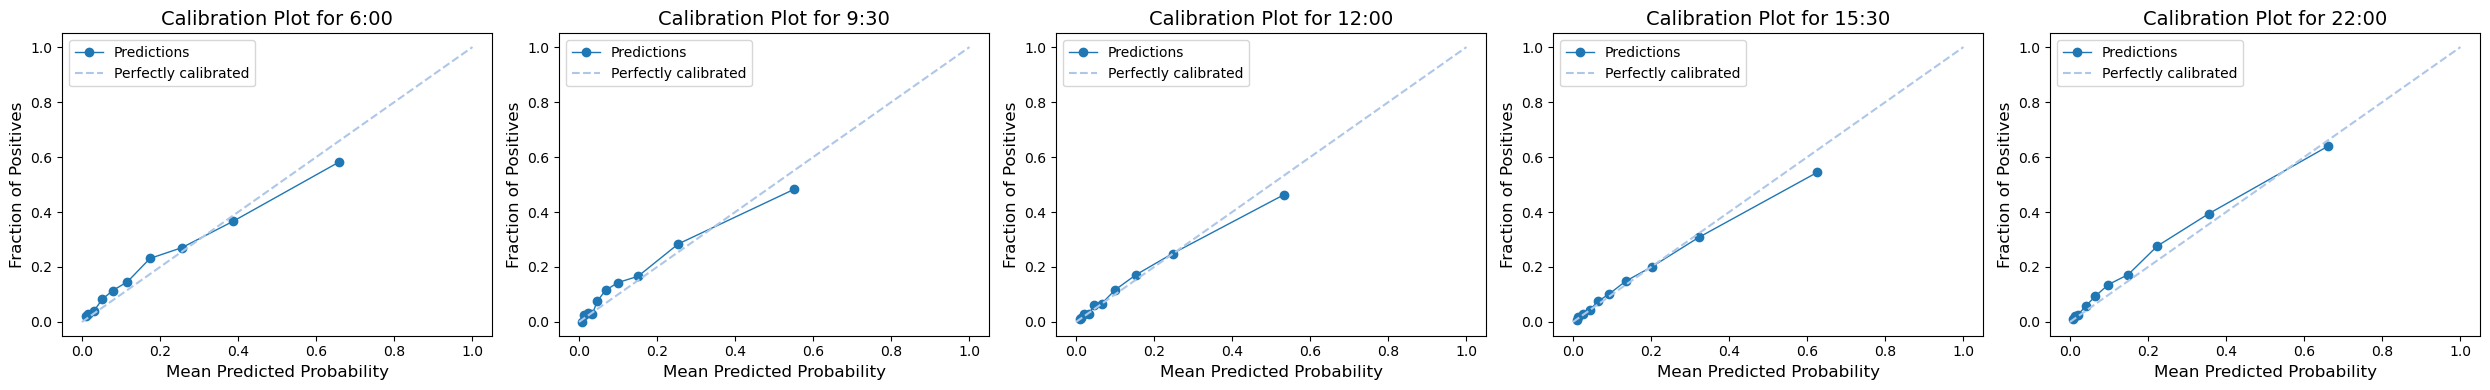

In [39]:
def plot_calibration(prediction_times):
    num_plots = len(prediction_times)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 5, 4))

    for i, prediction_time_ in enumerate(prediction_times):
        X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = prediction_time_, data_path = full_path, single_snapshot_per_visit = False, model_only = False)

        prob_true, prob_pred = calibration_curve(y_test, pipeline.predict_proba(X_test)[:, 1], n_bins=10, strategy = 'quantile')

        ax = axs[i]

        hour, minutes = prediction_time_

        ax.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Predictions', color=primary_color)
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color=secondary_color)
        ax.set_title(f'Calibration Plot for {hour}:{minutes:02}', fontsize = 14)
        ax.set_xlabel('Mean Predicted Probability', fontsize = 12)
        ax.set_ylabel('Fraction of Positives', fontsize = 12)
        ax.legend()

    plt.tight_layout()

    calib_plot_path = media_file_path / 'calibration_plot_quantile'
    calib_plot_path = calib_plot_path.with_suffix('.png')
    
    plt.savefig(calib_plot_path)
    plt.show()

    
plot_calibration(prediction_times)

### Shap plots

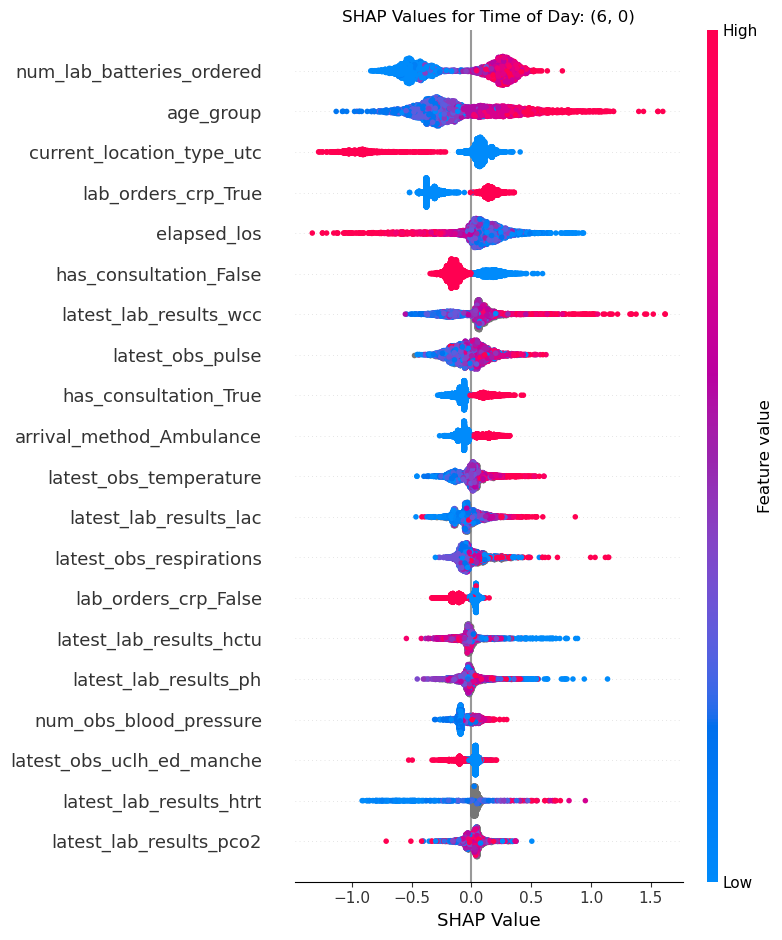

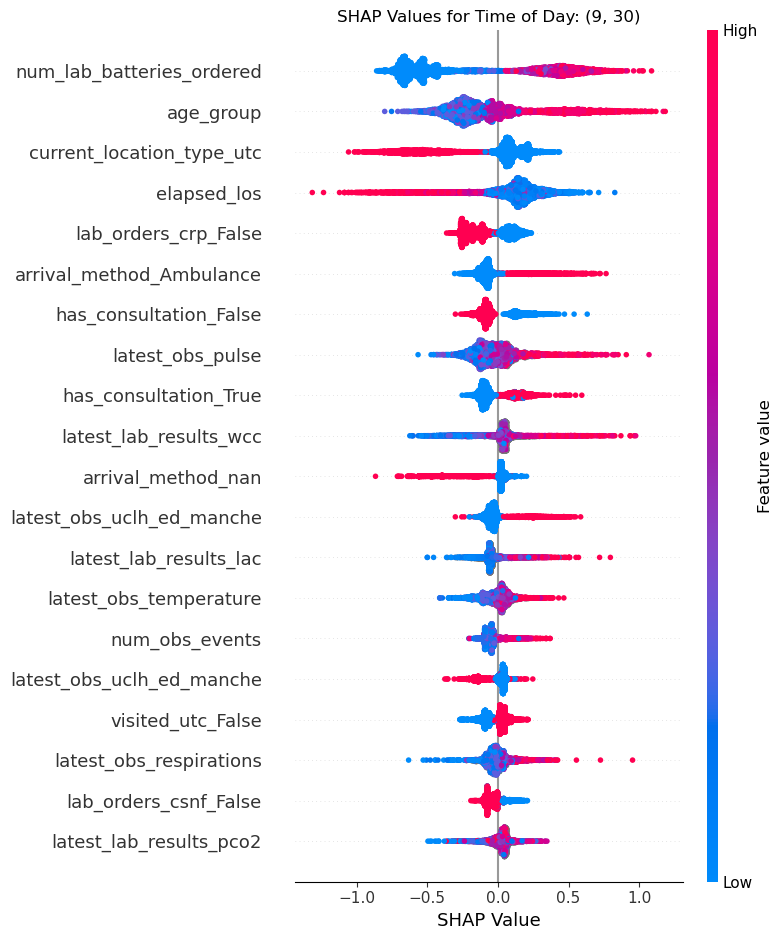

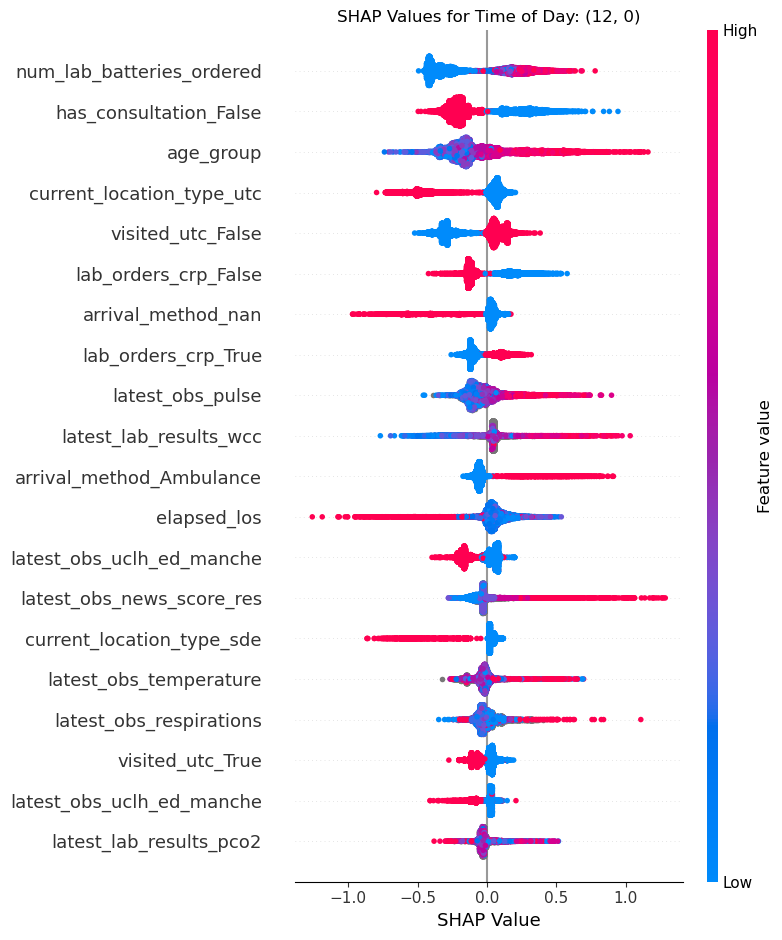

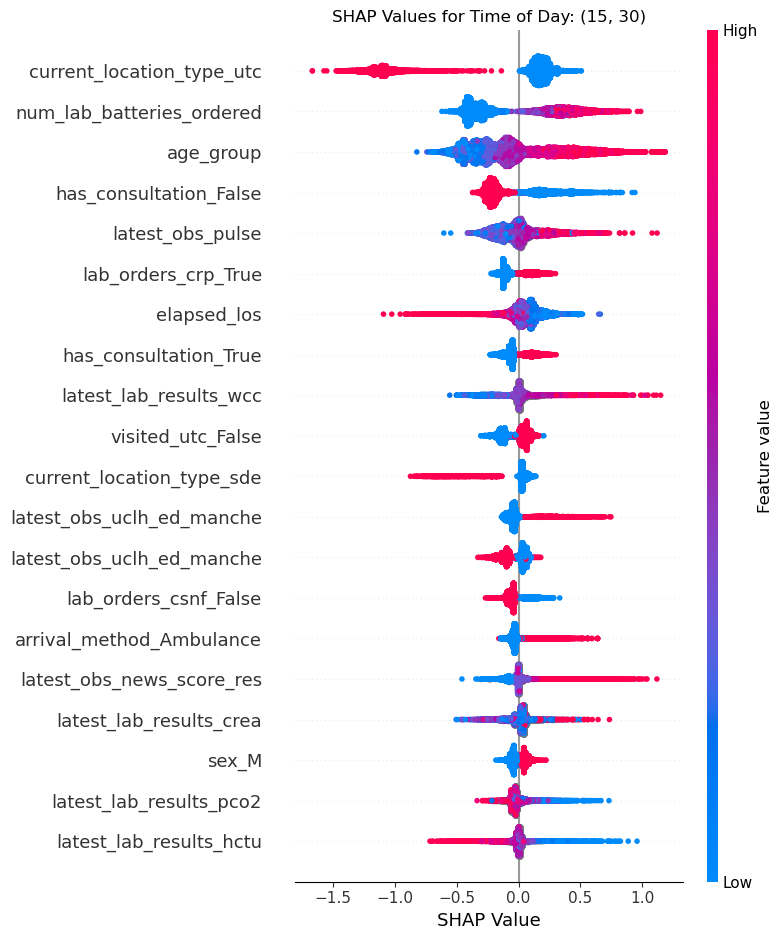

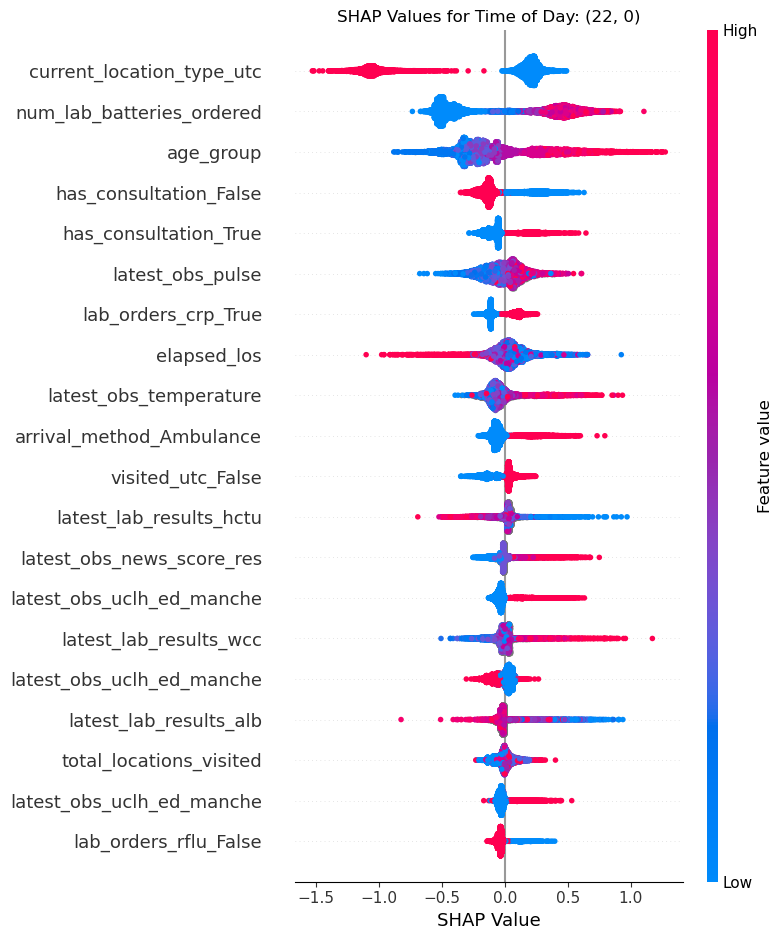

In [40]:
csv_filename = 'ed_visits.csv'
full_path = data_file_path / csv_filename

def plot_shap_individually(prediction_times):
    for i, prediction_time_ in enumerate(prediction_times):
        fig, ax = plt.subplots(figsize=(8, 12))
        X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = prediction_time_, data_path = full_path, single_snapshot_per_visit = False, model_only = False)
        transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
        transformed_cols = [col.split('__')[-1] for col in transformed_cols]
        truncated_cols = [col[:25] for col in transformed_cols]


        explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
        X_test = pipeline.named_steps['feature_transformer'].transform(X_test)
        shap_values = explainer.shap_values(X_test)
        
        shap.summary_plot(shap_values, X_test, feature_names=truncated_cols, color=primary_color, show=False)
        
        ax.set_title(f'SHAP Values for Time of Day: {prediction_time_}')
        ax.set_xlabel('SHAP Value')
        plt.tight_layout()

        MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', prediction_time_)
        shap_plot_path = str(media_file_path / 'shap_plot_') + MODEL__ED_ADMISSIONS__NAME +'.png'
    
        plt.savefig(shap_plot_path)
        plt.show()
    
plot_shap_individually(prediction_times)

### Feature plots

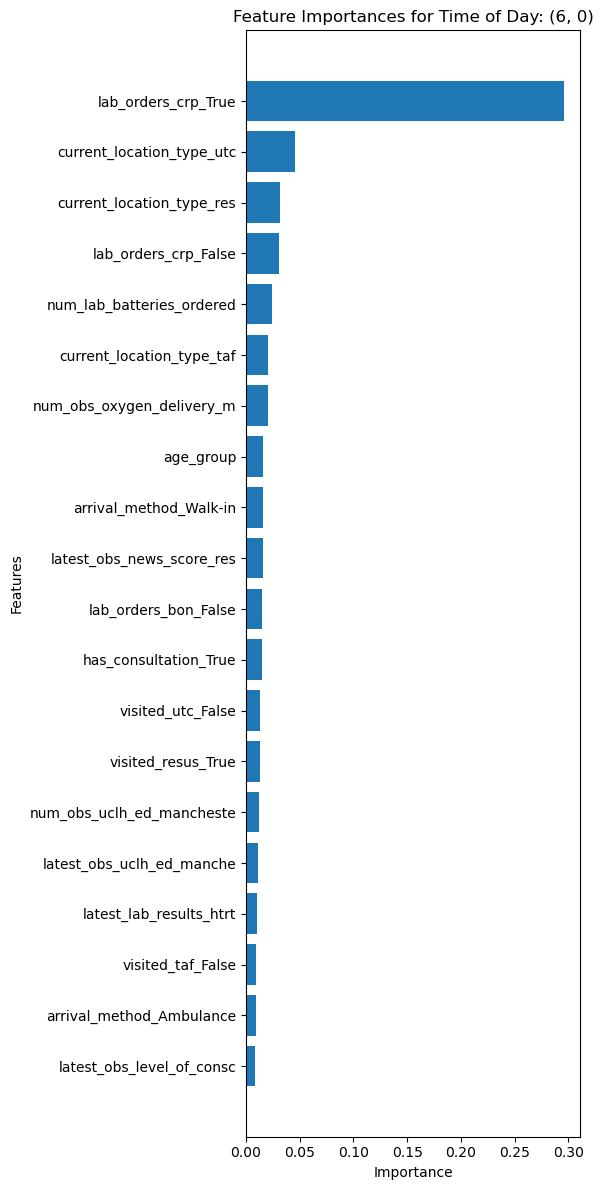

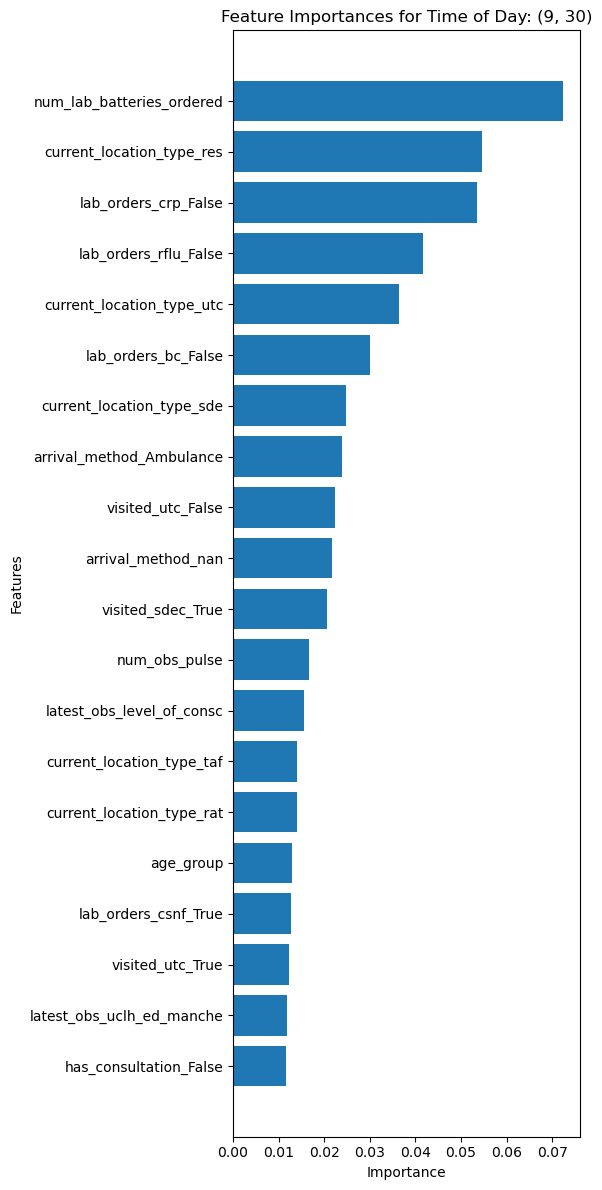

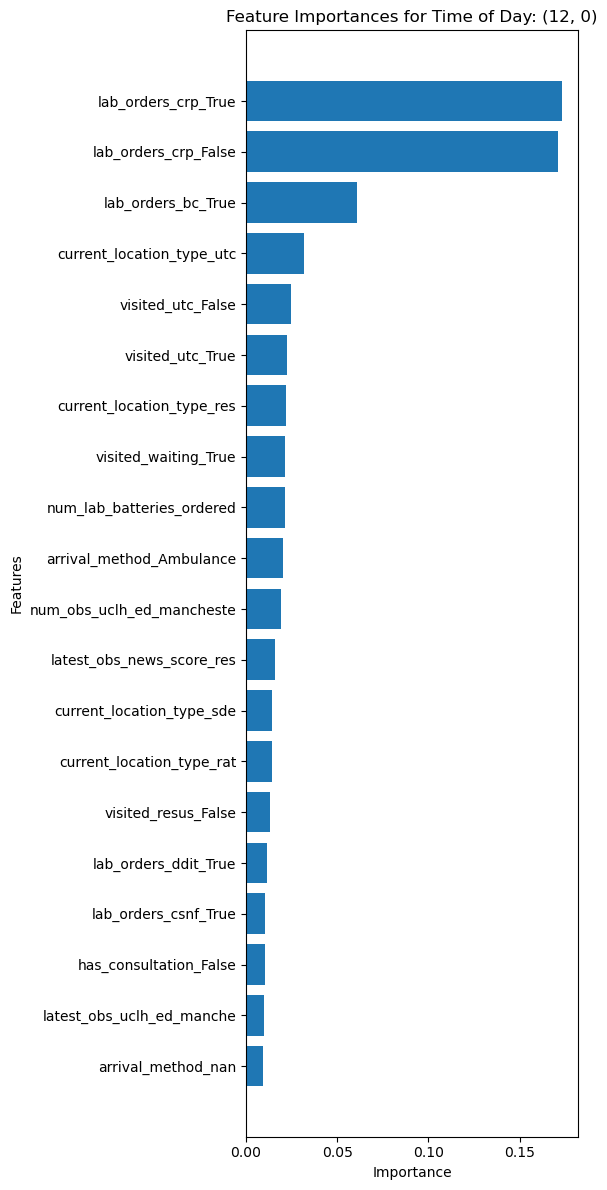

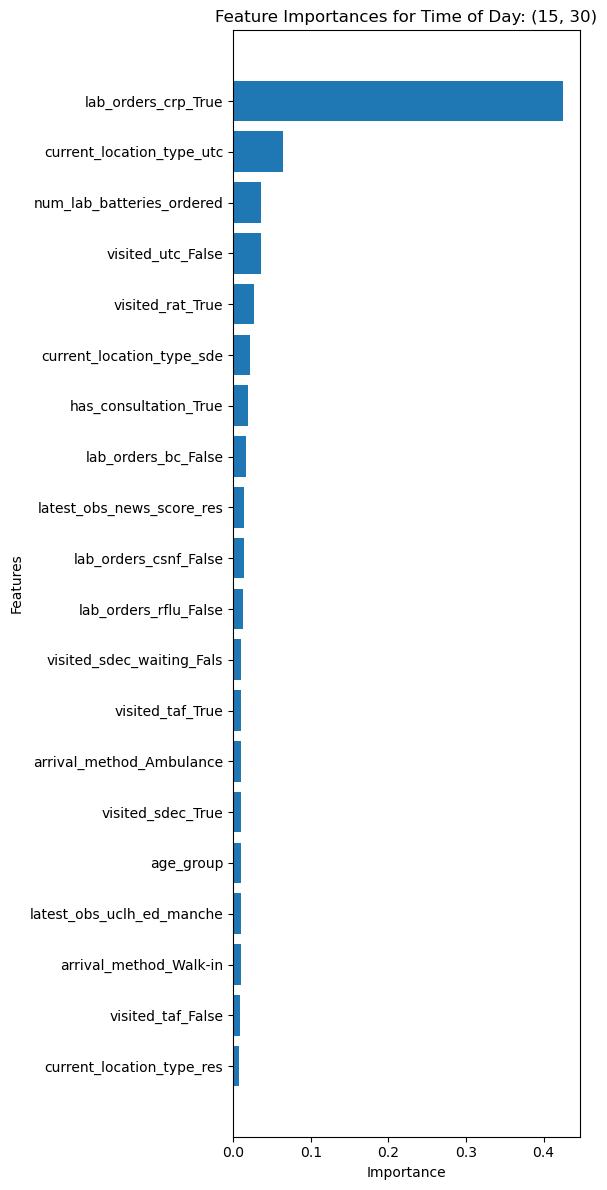

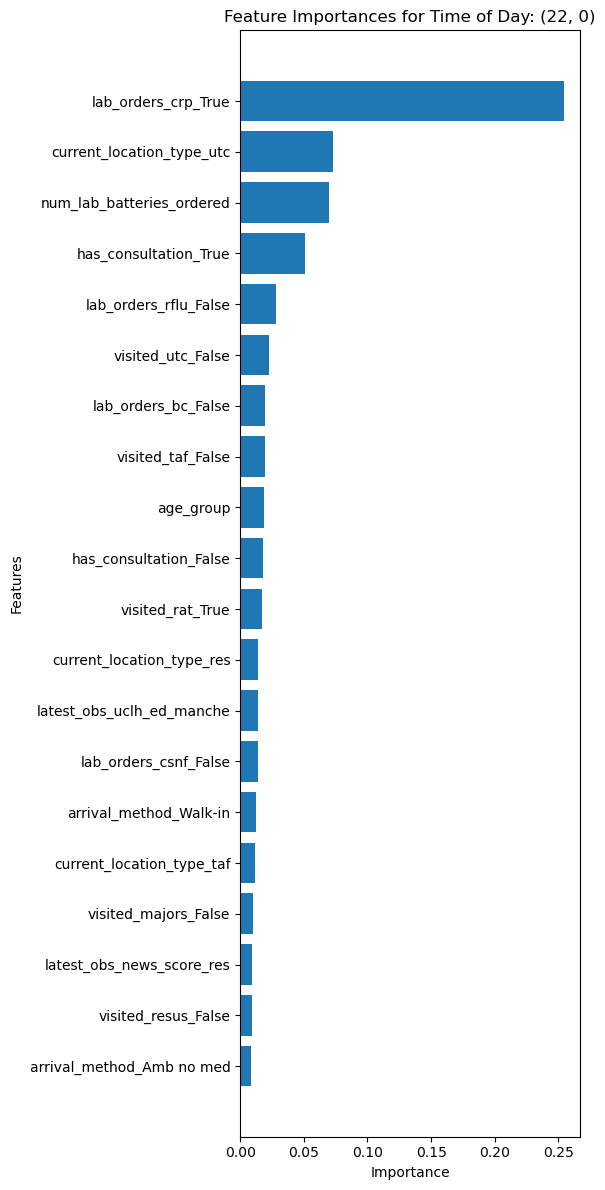

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances_individually(prediction_times):
    for prediction_time_ in prediction_times:
        pipeline = prepare_for_inference(
            model_file_path=model_file_path, 
            model_name='ed_admission', 
            prediction_time=prediction_time_, 
            data_path=full_path, 
            single_snapshot_per_visit=False, 
            model_only=True
        )
        
        transformed_cols = pipeline.named_steps['feature_transformer'].get_feature_names_out()
        transformed_cols = [col.split('__')[-1] for col in transformed_cols]
        truncated_cols = [col[:25] for col in transformed_cols]
        
        feature_importances = pipeline.named_steps['classifier'].feature_importances_
        indices = np.argsort(feature_importances)[-20:]  # Get indices of the top 20 features
        
        plt.figure(figsize=(6, 12))
        plt.title(f"Feature Importances for Time of Day: {prediction_time_}")
        plt.barh(range(len(indices)), feature_importances[indices], align="center", color=primary_color)
        plt.yticks(range(len(indices)), np.array(truncated_cols)[indices])
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()

        MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', prediction_time_)
        feature_plot_path = str(media_file_path / 'feature_plot_') + MODEL__ED_ADMISSIONS__NAME +'.png'
    
        plt.savefig(feature_plot_path)
        plt.show()

plot_feature_importances_individually(prediction_times)

### MADCAP plots

In [43]:
from viz.madcap_plot import plot_madcap, plot_madcap_by_group

In [44]:
from ed_admissions_data_retrieval import ed_admissions_get_data

csv_filename = 'ed_visits.csv'
full_path = data_file_path / csv_filename

visits_with_bed_request_feature = ed_admissions_get_data(full_path)


In [92]:
# X_test_with_br, y_test_with_br = preprocess_data(visits_with_bed_request_feature[visits_with_bed_request_feature.training_validation_test == 'test'], prediction_time_, exclude_from_training_data)
# print(len(X_test_with_br))

11835


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4327


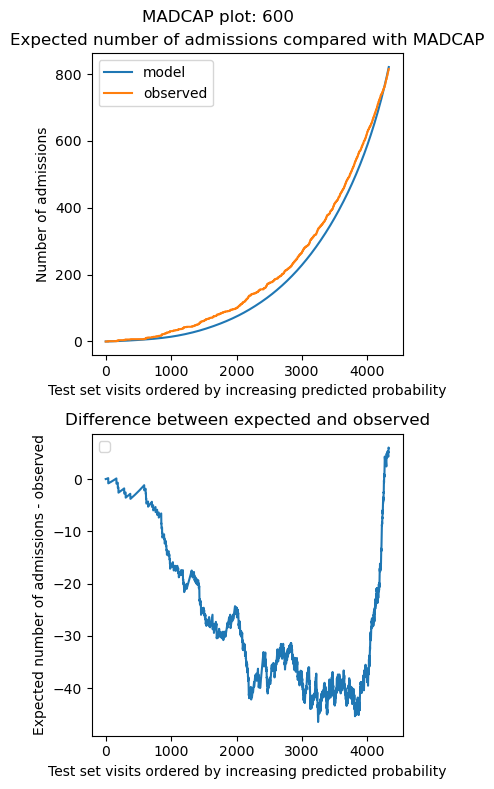

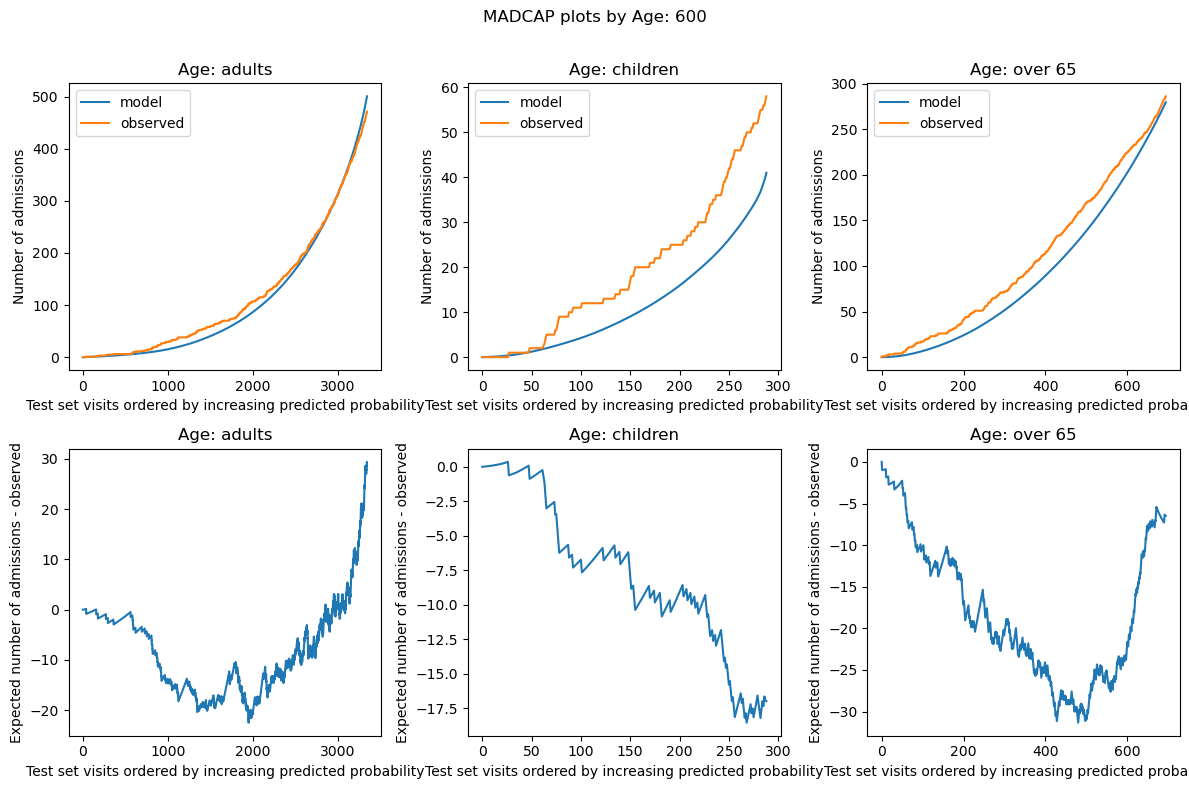

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6151


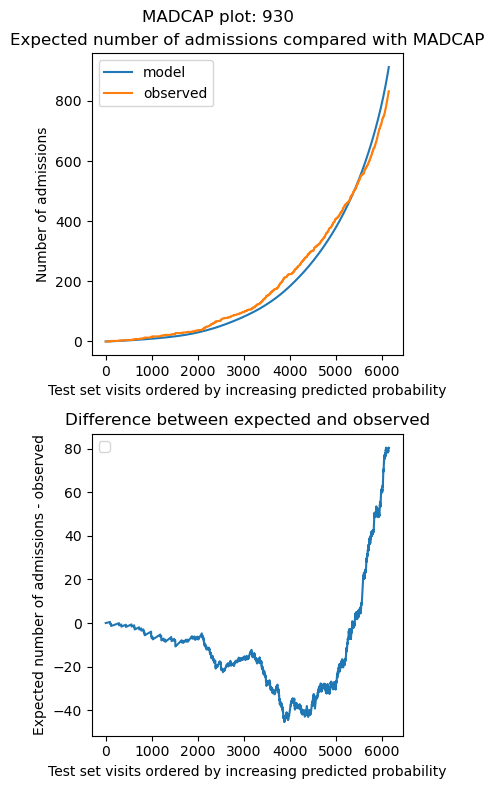

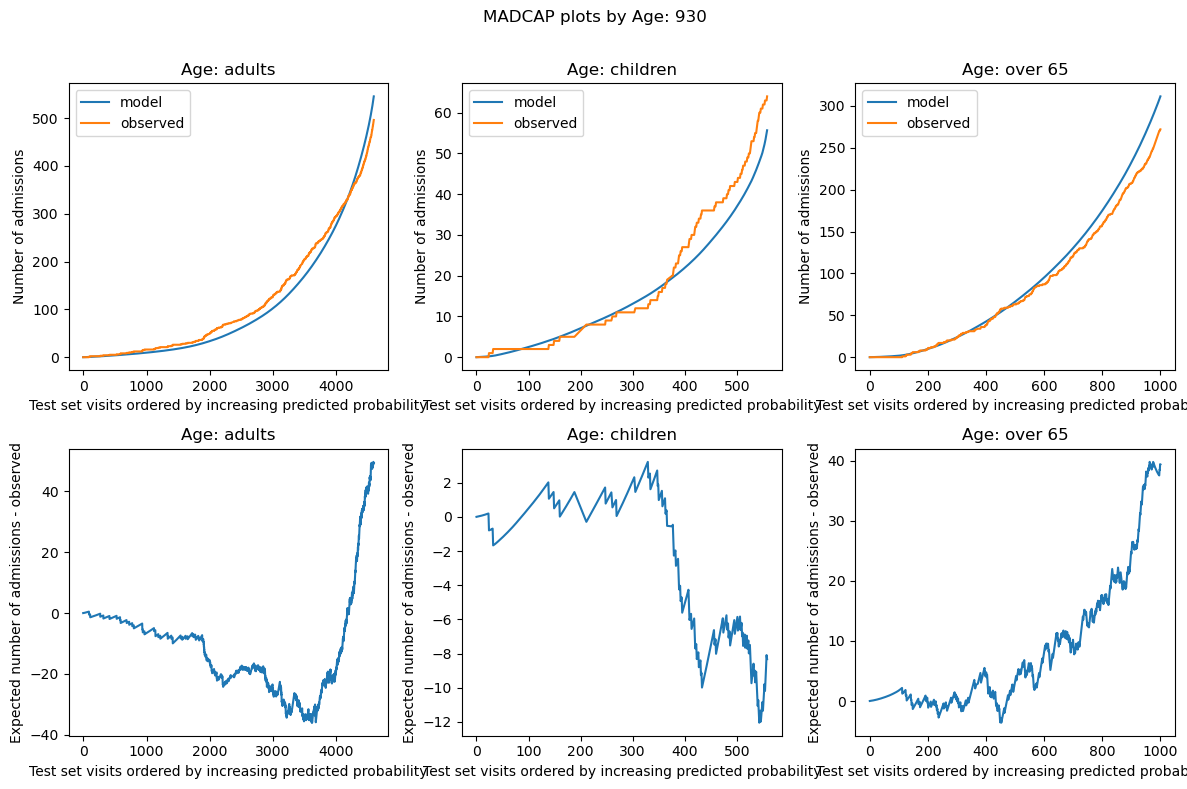

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10861


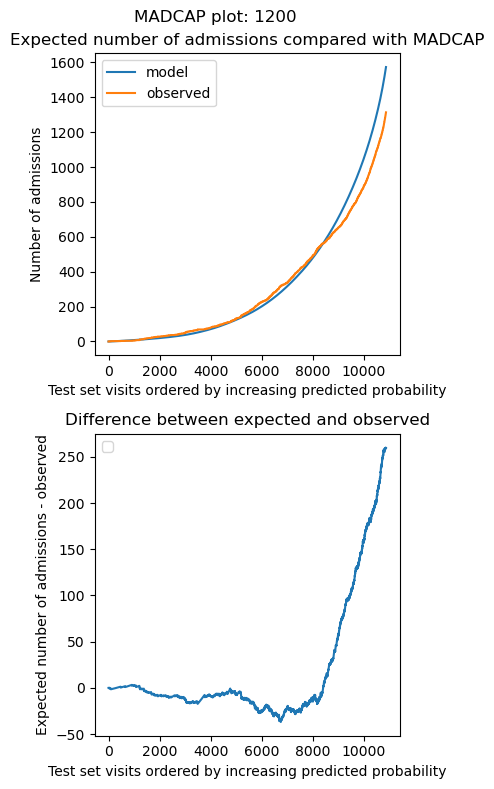

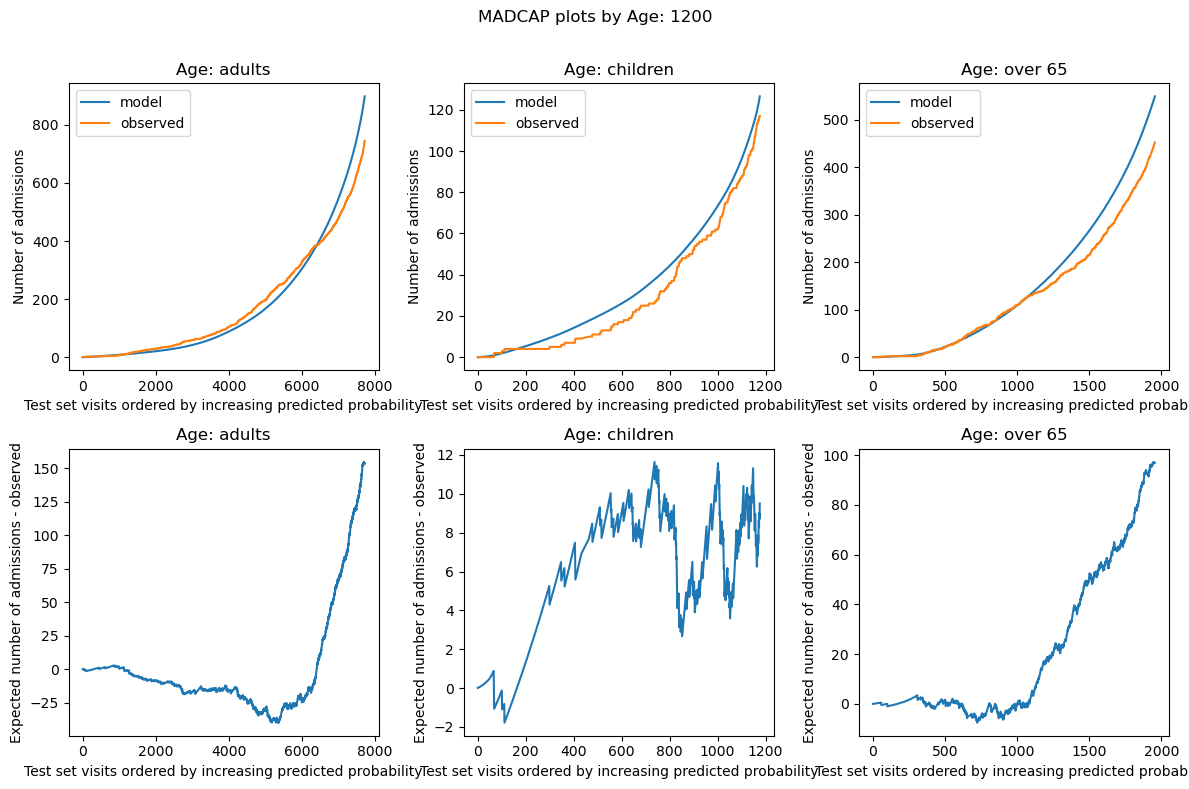

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


13190


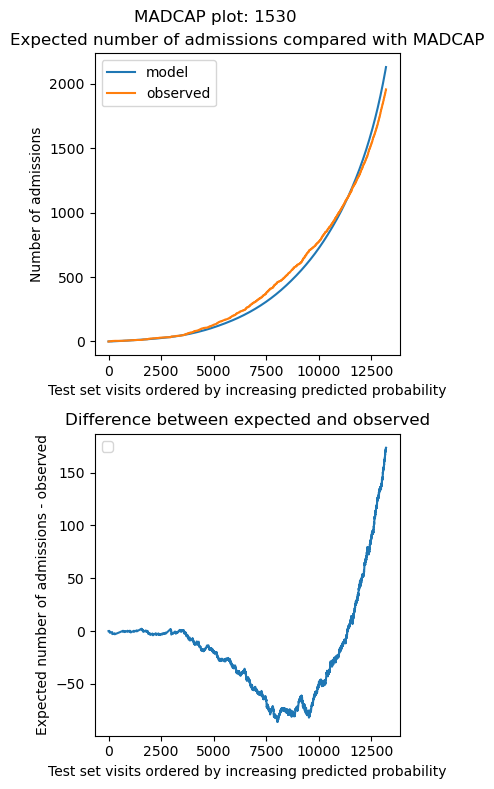

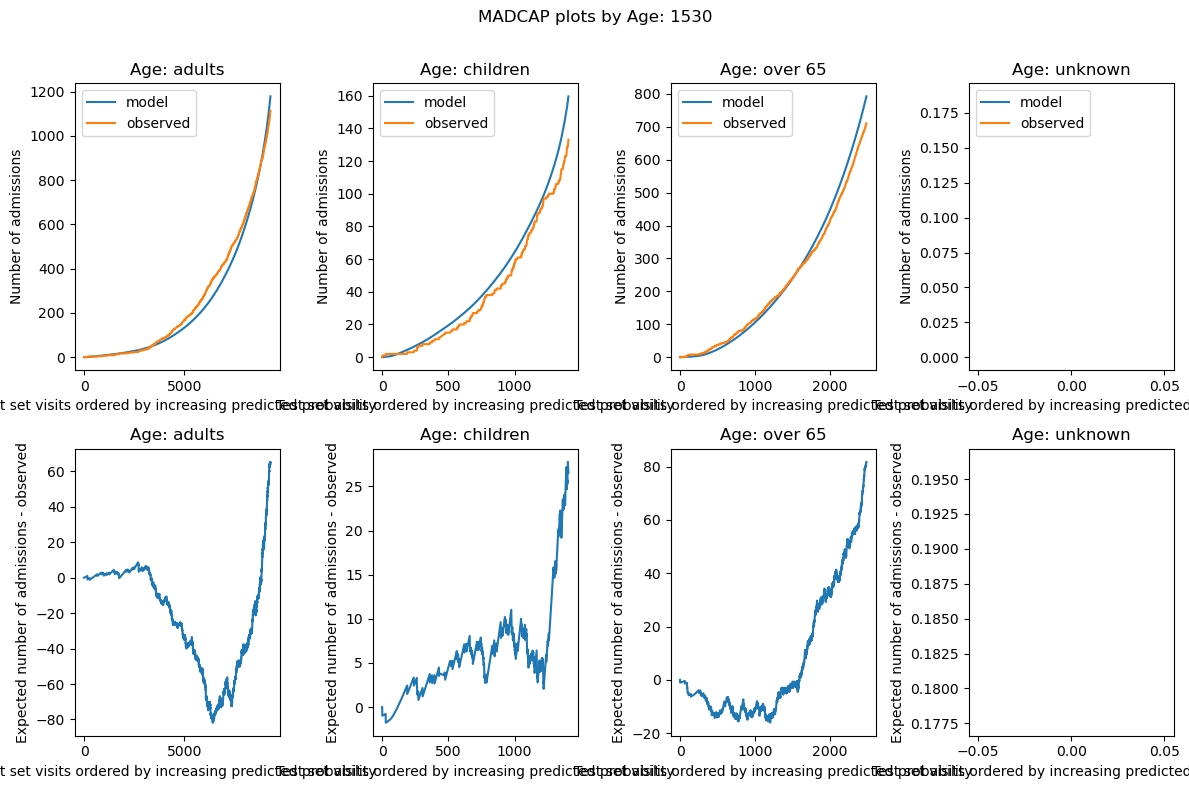

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10172


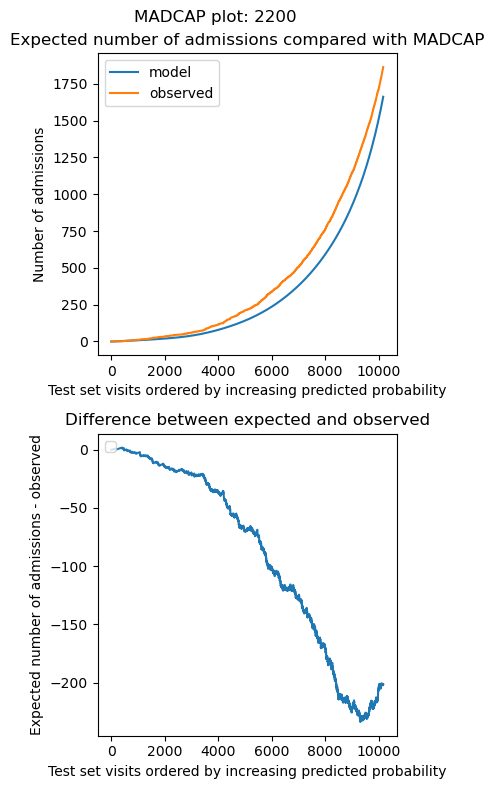

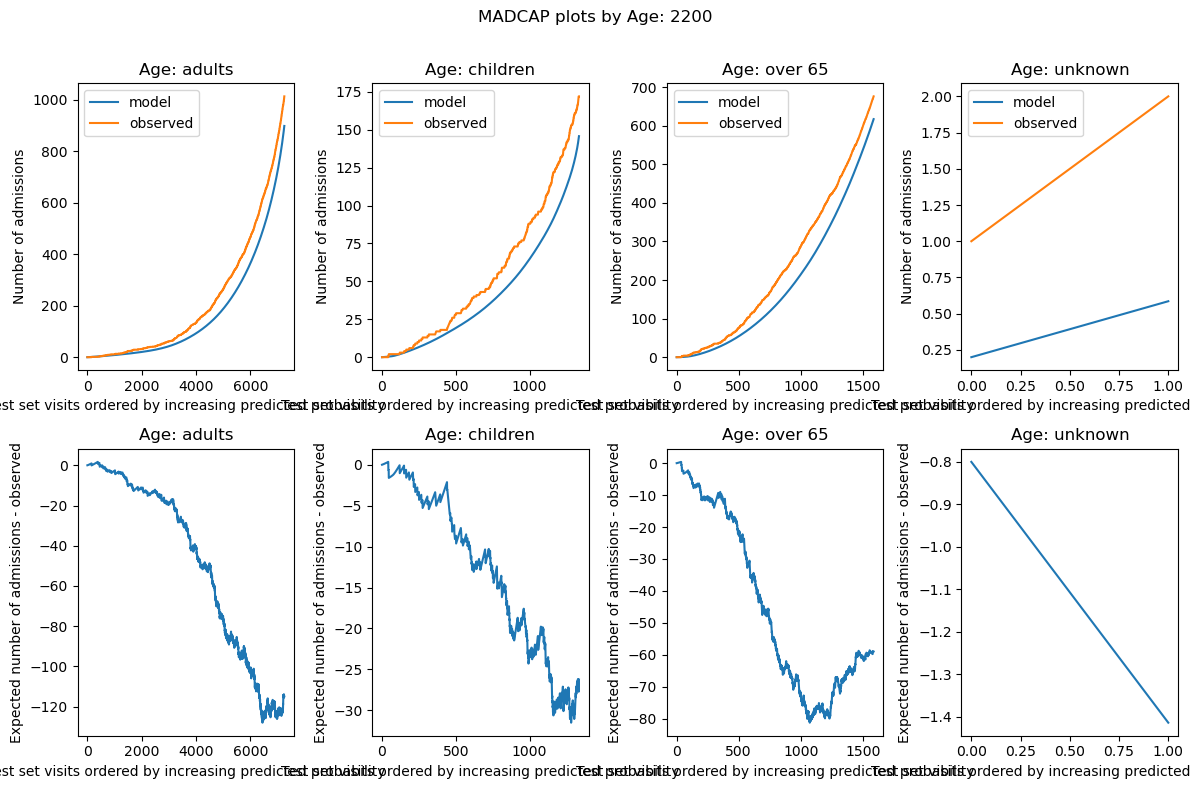

In [46]:

# Create a function to classify age groups
def classify_age_group(age_group):
    if age_group in ['0-17']:
        return 'children'
    elif age_group in ['18-24', '25-34', '35-44', '45-54', '55-64']:
        return 'adults'
    elif age_group in ['65-74', '75-102']:
        return 'over 65'
    else:
        return 'unknown' # Handle potential NaN or unexpected values
        
def generate_madcap_plots(prediction_times, grouping_var = None, grouping_var_name = None):


    for i, prediction_time_ in enumerate(prediction_times):
        hour, minutes = prediction_time_
        dataset = f'{hour}{minutes:02}'

        X_test_with_br, y_test_with_br = preprocess_data(visits_with_bed_request_feature[visits_with_bed_request_feature.training_validation_test == 'test'], prediction_time_, exclude_from_training_data)
        print(len(X_test_with_br))

        predict_proba = pipeline.predict_proba(X_test_with_br)[:,1]
        plot_madcap(predict_proba, y_test_with_br, dataset, media_file_path)

        # if grouping_var: 
        #     group = X_test_with_br[grouping_var].astype(str)
        #     plot_madcap_by_group(predict_proba, y_test_with_br , group, 
        #                          dataset, grouping_var_name, media_file_path)

        group = X_test_with_br['age_group'].apply(classify_age_group)
        plot_madcap_by_group(predict_proba, y_test_with_br , group, 
                                 dataset, grouping_var_name, media_file_path)

generate_madcap_plots(prediction_times, 'age_group', 'Age')